In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import *

In [2]:
class Measurement(object):
    def __init__(self, num, error=None):
        self._num = num
        if error is None:
            self._error = num ** 0.5 # Assume Poisson statistics
        else:
            self._error = error
            
    def __repr__(self):
        return u"{0}{1}{2:.1}".format(self._num, unichr(2213), self._error).encode('ascii', 'replace')
    
    def __add__(self, other):
        """ Add two measurements and their errors
        """
        if type(other) is type(5):
            o = Measurement(other, 0)
        else:
            o = other
        s = self._num + o._num
        e = (self._error ** 2 + o._error ** 2) ** 0.5
        return Measurement(s, e)
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __div__(self, other):
        s = self._num / other._num
        e = (self._error ** 2 / other._num ** 2 - self._num ** 2 / other._num ** 4 * other._error ** 2) ** 0.5
        return Measurement(s, e)

In [3]:
class SimpleExperiment(object):
    def __init__(self):
        self._background_filename = None
        self._data_file = None
        self._data = None
        self._background = None
        self._background_rate = None
        self._count_rate = None
        self._data_times = None
        self._background_times = None
        self._deadtime = None
    
    @property
    def background_file(self):
        return self._background_file
    
    @background_file.setter
    def background_file(self, filename):
        self._background_file = filename
    
    @property
    def data_file(self):
        return self._data_file
    
    @data_file.setter
    def data_file(self, filename):
        self._data_file = filename
    
    def fileread(self, filename):
        with open(filename, 'r') as f:
            lines = f.readlines()
            lines = lines[11:]
            splitlines = [l.split("\t") for l in lines]
            return splitlines
    
    @property
    def data(self):
        if self._data is None:
            self._data = [Measurement(int(l[2])) for l in self.fileread(self.data_file)]
        return self._data
    
    @property
    def background(self):
        if self._background is None:
            self._background = [Measurement(int(l[2])) for l in self.fileread(self.background_file)]
        return self._background
    
    @property
    def count_errors(self):
        return [n**0.5 for n in self.data]
    
    @property
    def background_errors(self):
        return [n**0.5 for n in self.data]
    
    @property
    def deadtime(self):
        return self._deadtime
    
    @deadtime.setter
    def deadtime(self, time):
        self._deadtime = time
        
    @property
    def background_times(self):
        if self._background_times is None:
            self._background_times = [Measurement(float(l[3])) for l in self.fileread(self.background_file)]
        return self._background_times
        
    @property
    def count_times(self):
        if self._count_times is None:
            self._count_times = [Measurement(float(l[3])) for l in self.fileread(self.data_file)]
        return self._count_times
        
    @property
    def background_countrate(self):
        return sum(self.background) / sum(self.background_times)
    
    def deadtimecorrect(self):
        self._data = [c / (1 - c * self.deadtime) for c in self.data]

In [4]:
fn = "Lab 5/background.tsv"
with open(fn, 'r') as f:
    lines = f.readlines()
    lines = lines[11:]
    splitlines = [l.split("\t") for l in lines]
    print(splitlines)

[['1', '900', '35', '60.00', '02/16/2017 06:06:28 PM', '\r\n'], ['2', '900', '25', '60.00', '02/16/2017 06:07:29 PM', '\r\n'], ['3', '900', '47', '60.00', '02/16/2017 06:08:30 PM', '\r\n'], ['4', '900', '29', '60.00', '02/16/2017 06:09:31 PM', '\r\n'], ['5', '900', '35', '60.00', '02/16/2017 06:10:32 PM', '\r\n']]


In [5]:
exp = SimpleExperiment()

In [6]:
exp.data_file = "Lab 5/Co-60_point.tsv"
exp.background_file = "Lab 5/background.tsv"

In [7]:
exp.data

[426?2e+01, 661?3e+01, 1302?4e+01, 3694?6e+01, 16014?1e+02]

In [8]:
exp.background

[35?6e+00, 25?5e+00, 47?7e+00, 29?5e+00, 35?6e+00]

In [9]:
exp.deadtimecorrect

<bound method SimpleExperiment.deadtimecorrect of <__main__.SimpleExperiment object at 0x10a5017d0>>

In [10]:
exp.deadtime = 266

In [11]:
exp.data

[426?2e+01, 661?3e+01, 1302?4e+01, 3694?6e+01, 16014?1e+02]

In [12]:
m = Measurement(1.5, .2)

In [13]:
m

1.5?0.2

In [14]:
unichr(2213)

u'\u08a5'

In [15]:
exp.data[0]._error

20.639767440550294

In [16]:
exp.background_countrate

0.57?0.03

In [17]:
bg = [ufloat(a._num, a._num**0.5) for a in exp.background]

In [18]:
exp.background

[35?6e+00, 25?5e+00, 47?7e+00, 29?5e+00, 35?6e+00]

In [19]:
bg

[35.0+/-5.916079783099616,
 25.0+/-5.0,
 47.0+/-6.855654600401044,
 29.0+/-5.385164807134504,
 35.0+/-5.916079783099616]

In [20]:
sum(bg)

171.0+/-13.076696830622021

In [21]:
171**.5

13.076696830622021

In [22]:
times = [ufloat(exp.background_times[i]._num, 0.) for i in range(len(exp.background_times))]

In [23]:
times

[60.0+/-0, 60.0+/-0, 60.0+/-0, 60.0+/-0, 60.0+/-0]

In [24]:
bg / times

TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [26]:
bgr = [bg[i] / times[i] for i in range(len(times))]

In [27]:
bgr

[0.5833333333333334+/-0.09860132971832694,
 0.4166666666666667+/-0.08333333333333333,
 0.7833333333333333+/-0.11426091000668406,
 0.48333333333333334+/-0.08975274678557506,
 0.5833333333333334+/-0.09860132971832694]

In [28]:
bg = np.array(bg)
times = np.array(times)

In [29]:
bg / times

array([0.5833333333333334+/-0.09860132971832694,
       0.4166666666666667+/-0.08333333333333333,
       0.7833333333333333+/-0.11426091000668406,
       0.48333333333333334+/-0.08975274678557506,
       0.5833333333333334+/-0.09860132971832694], dtype=object)

In [30]:
np.mean(bg / times)

0.5700000000000001+/-0.04358898943540674

TypeError: can't convert an affine function (<class 'uncertainties.core.AffineScalarFunc'>) to float; use x.nominal_value

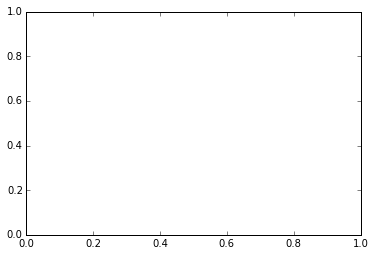

In [34]:
plt.plot(bg / times)
plt.show()